1. Introdução

1.1 Pandemia COVID-19

> A COVID-19 é uma infecção respiratória aguda causada pelo coronavírus SARS-CoV-2, potencialmente grave, de elevada transmissibilidade e de distribuição global. Fonte: Governo brasileiro ([link](https://www.gov.br/saude/pt-br/coronavirus/o-que-e-o-coronavirus)).

A disponibilidade de dados sobre a evolução da pandemia no tempo em uma determinada região geográfica é fundamental para o seu combate! Este projeto busca construir um dashboard de dados para exploração e visualização interativa de dados sobre o avanço de casos e da vacinação do Brasil. 

1.2 Data

1.2.1 Casos COVID-19

Os dados sobre **casos da COVID-19** são compilados pelo centro de ciência de sistemas e engenharia da universidade americana **John Hopkins** ([link](https://www.jhu.edu)). Os dados são atualizados diariamente deste janeiro de 2020 com uma granularidade temporal de dias e geográfica de regiões de países (estados, condados, etc.). O website do projeto pode ser acessado neste [link](https://systems.jhu.edu/research/public-health/ncov/) enquanto os dados, neste [link](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports). Abaixo estão descritos os dados derivados do seu processamento.

 - **date**: data de referência;
 - **state**: estado;
 - **country**: país;
 - **population**: população estimada;
 - **confirmed**: número acumulado de infectados;
 - **confirmed_1d**: número diário de infectados;
 - **confirmed_moving_avg_7d**: média móvel de 7 dias do número diário de infectados;
 - **confirmed_moving_avg_7d_rate_14d**: média móvel de 7 dias dividido pela média móvel de 7 dias de 14 dias atrás;
 - **deaths**: número acumulado de mortos;
 - **deaths_1d**: número diário de mortos;
 - **deaths_moving_avg_7d**: média móvel de 7 dias do número diário de mortos;
 - **deaths_moving_avg_7d**: média móvel de 7 dias dividido pela média móvel de 7 dias de 14 dias atrás;
 - **month**: mês de referência;
 - **year**: ano de referência.

1.2.2 Vacinação COVID-19

Os dados sobre **vacinação da COVID-19** são compilados pelo projeto Nosso Mundo em Dados (*Our World in Data* ou OWID) da universidade britânica de **Oxford** ([link](https://www.ox.ac.uk)). Os dados são **atualizados diariamente** deste janeiro de 2020 com uma **granularidade temporal de dias e geográfica de países**. O website do projeto pode ser acessado neste [link](https://ourworldindata.org) enquanto os dados, neste [link](https://covid.ourworldindata.org/data/owid-covid-data.csv). Abaixo estão descritos os dados derivados do seu processamento.

 - **date**: data de referência;
 - **country**: país;
 - **population**: população estimada;
 - **total**: número acumulado de doses administradas;
 - **one_shot**: número acumulado de pessoas com uma dose;
 - **one_shot_perc**: número acumulado relativo de pessoas com uma dose;
 - **two_shots**: número acumulado de pessoas com duas doses;
 - **two_shot_perc**: número acumulado relativo de pessoas com duas doses;
 - **three_shots**: número acumulado de pessoas com três doses;
 - **three_shot_perc**: número acumulado relativo de pessoas com três doses;
 - **month**: mês de referência;
 - **year**: ano de referência.

2. Packages and libraries

In [2]:
import math
from typing import Iterator
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

3. Exploratory data analysis

> **3.1 Cases**

3.1.1 Extract 

In [3]:
URL_cases = 'C:/Users/Matheus Rodrigues/OneDrive/Área de Trabalho/portfolio/data-science-portfolio/covid-dashboard/03-09-2023.csv'
cases = pd.read_csv(URL_cases)

In [4]:
cases.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2023-03-10 04:21:03,33.93911,67.709953,209451,7896,NaN,NaN,Afghanistan,538.042451,3.769855
1,NaN,NaN,NaN,Albania,2023-03-10 04:21:03,41.15330,20.168300,334457,3598,NaN,NaN,Albania,11621.968170,1.075774
2,NaN,NaN,NaN,Algeria,2023-03-10 04:21:03,28.03390,1.659600,271496,6881,NaN,NaN,Algeria,619.132366,2.534476
3,NaN,NaN,NaN,Andorra,2023-03-10 04:21:03,42.50630,1.521800,47890,165,NaN,NaN,Andorra,61981.492267,0.344540
4,NaN,NaN,NaN,Angola,2023-03-10 04:21:03,-11.20270,17.873900,105288,1933,NaN,NaN,Angola,320.352770,1.835917


Nota-se que a granularidade do conjunto de dados em 'cases' é de **um dia**.

In [5]:
# Define a função 'date_range' que itera dentro de um intervalo de tempo 

def date_range(start_date: datetime, end_date: datetime) -> Iterator[datetime]:
  date_range_days: int = (end_date - start_date).days
  for lag in range(date_range_days):
    yield start_date + timedelta(lag)

In [6]:
start_date = datetime(2021,  1,  1)
end_date   = datetime(2021, 12, 31)

In [7]:
# LIntera sobre o intervalo de 'start_date' e 'end_date'
# "Scapring' no GitHub para obtenção dos dados de interesse 
# Limpas as colunas desnecessárias e filta os dados onde 'Country_Region' = 'Brazil'
# Cria uma coluna 'Date' para gerar referência temporal no dado
# Concatena os dado diários em 'cases'

cases = None
cases_is_empty = True

for date in date_range(start_date=start_date, end_date=end_date):

  date_str = date.strftime('%m-%d-%Y')
  data_source_url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{date_str}.csv'

  case = pd.read_csv(data_source_url, sep=',')

  case = case.drop(['FIPS', 'Admin2', 'Last_Update', 'Lat', 'Long_', 'Recovered', 'Active', 'Combined_Key', 'Case_Fatality_Ratio'], axis=1)
  case = case.query('Country_Region == "Brazil"').reset_index(drop=True)
  case['Date'] = pd.to_datetime(date.strftime('%Y-%m-%d'))
  if cases_is_empty:
    cases = case
    cases_is_empty = False
  else:
    cases = pd.concat([cases, case], axis= 0, ignore_index=True)

In [8]:
cases.query('Province_State == "Sao Paulo"').head()

,Province_State,Country_Region,Confirmed,Deaths,Incident_Rate,Date
24,Sao Paulo,Brazil,1466191,46775,3192.990778,2021-01-01
51,Sao Paulo,Brazil,1467953,46808,3196.827966,2021-01-02
78,Sao Paulo,Brazil,1471422,46845,3204.382565,2021-01-03
105,Sao Paulo,Brazil,1473670,46888,3209.278136,2021-01-04
132,Sao Paulo,Brazil,1486551,47222,3237.329676,2021-01-05


3.1.2 Data Wrangling

In [9]:
cases.head()

,Province_State,Country_Region,Confirmed,Deaths,Incident_Rate,Date
0,Acre,Brazil,41689,796,4726.992352,2021-01-01
1,Alagoas,Brazil,105091,2496,3148.928928,2021-01-01
2,Amapa,Brazil,68361,926,8083.066602,2021-01-01
3,Amazonas,Brazil,201574,5295,4863.536793,2021-01-01
4,Bahia,Brazil,494684,9159,3326.039611,2021-01-01


In [10]:
cases.shape

(9828, 6)

In [11]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9828 entries, 0 to 9827
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province_State  9828 non-null   object        
 1   Country_Region  9828 non-null   object        
 2   Confirmed       9828 non-null   int64         
 3   Deaths          9828 non-null   int64         
 4   Incident_Rate   9828 non-null   float64       
 5   Date            9828 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 460.8+ KB


In [12]:
# Renomeia os nomes das colunas 'Province_State' e 'Country_Region'
# Converte para minúsculas para garantir uniformidade 

cases = cases.rename(
  columns={
    'Province_State': 'state',
    'Country_Region': 'country'
  }
)

for col in cases.columns:
  cases = cases.rename(columns={col: col.lower()})

In [13]:
# Define um dicionário com a chave sendo o antigo e o valor sendo o novo nome em 'states'
# Aplica uma função anônima que verifica se o nome do estado precisa ser corrigido e faz a alteração utilizando 'states_map'

states_map = {
    'Amapa': 'Amapá',
    'Ceara': 'Ceará',
    'Espirito Santo': 'Espírito Santo',
    'Goias': 'Goiás',
    'Para': 'Pará',
    'Paraiba': 'Paraíba',
    'Parana': 'Paraná',
    'Piaui': 'Piauí',
    'Rondonia': 'Rondônia',
    'Sao Paulo': 'São Paulo'
}

cases['state'] = cases['state'].apply(lambda state: states_map.get(state)
                                       if state in states_map.keys() else state)

In [14]:
# Adicionando chaves temporais para facilitar a criação do dashboard

cases['month'] = cases['date'].apply(lambda date: date.strftime('%Y-%m'))
cases['year']  = cases['date'].apply(lambda date: date.strftime('%Y'))

In [15]:
# Adicionando a coluna 'population' com base em estimativa

cases['population'] = round(100000 * (cases['confirmed'] / cases['incident_rate']))
cases = cases.drop('incident_rate', axis=1)

In [16]:
# Inicializa a variável 'cases_' vazia
# Inicializa a variável 'cases_is_empty' com um booleano
# Define a função 'get_trend' para verificar a estabilidade dos casos

cases_ = None
cases_is_empty = True

def get_trend(rate: float) -> str:

  if np.isnan(rate):
    return np.NaN

  if rate < 0.75:    # Se a divisão for menor que 0.75 (correção 0.85)
    status = 'downward'
  elif rate > 1.15:
    status = 'upward'
  else:
    status = 'stable'

  return status

In [17]:
# Itera sobre o 'state' individulamente e processa os dados para cada estado individualmente
# Utiliza 'confirmed_1d', 'confirmed_moving_avg_7d', 'confirmed_moving_avg_7d_rate_14d' para gerar métricas
# Calcula as diferenças diárias, médias móveis, taxas de variação e tendências para casos confirmados e mortes
# Acumula e combina os dados processados de cada estado
# Atualiza o dataframe 'cases' com os dados processados e limpa a variável temporária

for state in cases['state'].drop_duplicates():

  cases_per_state = cases.query(f'state == "{state}"').reset_index(drop=True)
  cases_per_state = cases_per_state.sort_values(by=['date'])

  cases_per_state['confirmed_1d'] = cases_per_state['confirmed'].diff(periods=1)
  cases_per_state['confirmed_moving_avg_7d'] = np.ceil(cases_per_state['confirmed_1d'].rolling(window=7).mean())
  cases_per_state['confirmed_moving_avg_7d_rate_14d'] = cases_per_state['confirmed_moving_avg_7d']/cases_per_state['confirmed_moving_avg_7d'].shift(periods=14)
  cases_per_state['confirmed_trend'] = cases_per_state['confirmed_moving_avg_7d_rate_14d'].apply(get_trend)

  cases_per_state['deaths_1d'] = cases_per_state['deaths'].diff(periods=1)
  cases_per_state['deaths_moving_avg_7d'] = np.ceil(cases_per_state['deaths_1d'].rolling(window=7).mean())
  cases_per_state['deaths_moving_avg_7d_rate_14d'] = cases_per_state['deaths_moving_avg_7d']/cases_per_state['deaths_moving_avg_7d'].shift(periods=14)
  cases_per_state['deaths_trend'] = cases_per_state['deaths_moving_avg_7d_rate_14d'].apply(get_trend)

  if cases_is_empty:
    cases_ = cases_per_state
    cases_is_empty = False
  else:
    cases_ = pd.concat([cases_, cases_per_state],axis=0, ignore_index=True)

cases = cases_
cases_ = None

In [18]:
# Garante que os tipos dos dados estejam consistentes após as transformações 

cases['population'] = cases['population'].astype('Int64')
cases['confirmed_1d'] = cases['confirmed_1d'].astype('Int64')
cases['confirmed_moving_avg_7d'] = cases['confirmed_moving_avg_7d'].astype('Int64')
cases['deaths_1d'] = cases['deaths_1d'].astype('Int64')
cases['deaths_moving_avg_7d'] = cases['deaths_moving_avg_7d'].astype('Int64')

In [19]:
# Reordena as colunas do dataframe na ordem de interesse

cases = cases[['date', 'country', 'state', 'population', 'confirmed', 'confirmed_1d', 
               'confirmed_moving_avg_7d', 'confirmed_moving_avg_7d_rate_14d', 'confirmed_trend',
                'deaths', 'deaths_1d', 'deaths_moving_avg_7d', 'deaths_moving_avg_7d_rate_14d', 
                'deaths_trend', 'month', 'year']]

In [20]:
cases.head(15)

,date,country,state,population,confirmed,confirmed_1d,confirmed_moving_avg_7d,confirmed_moving_avg_7d_rate_14d,confirmed_trend,deaths,deaths_1d,deaths_moving_avg_7d,deaths_moving_avg_7d_rate_14d,deaths_trend,month,year
0,2021-01-01,Brazil,Acre,881935,41689,<NA>,<NA>,NaN,NaN,796,<NA>,<NA>,NaN,NaN,2021-01,2021
1,2021-01-02,Brazil,Acre,881935,41941,252,<NA>,NaN,NaN,798,2,<NA>,NaN,NaN,2021-01,2021
2,2021-01-03,Brazil,Acre,881935,42046,105,<NA>,NaN,NaN,802,4,<NA>,NaN,NaN,2021-01,2021
3,2021-01-04,Brazil,Acre,881935,42117,71,<NA>,NaN,NaN,806,4,<NA>,NaN,NaN,2021-01,2021
4,2021-01-05,Brazil,Acre,881935,42170,53,<NA>,NaN,NaN,808,2,<NA>,NaN,NaN,2021-01,2021
5,2021-01-06,Brazil,Acre,881935,42378,208,<NA>,NaN,NaN,814,6,<NA>,NaN,NaN,2021-01,2021
6,2021-01-07,Brazil,Acre,881935,42478,100,<NA>,NaN,NaN,821,7,<NA>,NaN,NaN,2021-01,2021
7,2021-01-08,Brazil,Acre,881935,42814,336,161,NaN,NaN,823,2,4,NaN,NaN,2021-01,2021
8,2021-01-09,Brazil,Acre,881935,42908,94,139,NaN,NaN,823,0,4,NaN,NaN,2021-01,2021
9,2021-01-10,Brazil,Acre,881935,43127,219,155,NaN,NaN,825,2,4,NaN,NaN,2021-01,2021


3.1.3 Data Load

In [21]:
# Salva os dados transformados em um arquivo .csv

cases.to_csv('./covid-cases.csv', sep=',', index=False)

> **3.1 Vaccines**

3.2.1 Extract 

In [22]:
# Carrega 'vaccines' com o conjunto de dados

vaccines = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', sep=',', parse_dates=[3], infer_datetime_format=True)

C:\Users\Matheus Rodrigues\AppData\Local\Temp\ipykernel_12532\1033115602.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  vaccines = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', sep=',', parse_dates=[3], infer_datetime_format=True)


In [23]:
vaccines.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN


In [24]:
# Filtra apenas os dados onde 'location' é igual a 'Brazil'
# Filtra as colunas de interesse

vaccines = vaccines.query('location == "Brazil"').reset_index(drop=True)
vaccines = vaccines[['location', 'population', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'date']]

In [25]:
vaccines.head()

,location,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,date
0,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-05
1,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-06
2,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-07
3,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-08
4,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-09


3.2.2 Data Wrangling

In [26]:
vaccines.head()

,location,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,date
0,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-05
1,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-06
2,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-07
3,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-08
4,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-09


In [27]:
vaccines.shape

(1674, 7)

In [28]:
vaccines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1674 entries, 0 to 1673
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   location                 1674 non-null   object        
 1   population               1674 non-null   int64         
 2   total_vaccinations       695 non-null    float64       
 3   people_vaccinated        691 non-null    float64       
 4   people_fully_vaccinated  675 non-null    float64       
 5   total_boosters           455 non-null    float64       
 6   date                     1674 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 91.7+ KB


In [29]:
# Preenche os valores nulos pelo valor anterior mais recente

vaccines = vaccines.fillna(method='ffill')

In [30]:
# Filtra as linhas com o período de interesse e redefine o index do datafram 

vaccines = vaccines[(vaccines['date'] >= '2021-01-01') & (vaccines['date'] <= '2021-12-31')].reset_index(drop=True)

In [31]:
# Renomeia as colunas do dataframe

vaccines = vaccines.rename(
  columns={
    'location': 'country',
    'total_vaccinations': 'total',
    'people_vaccinated': 'one_shot',
    'people_fully_vaccinated': 'two_shots',
    'total_boosters': 'three_shots',
  }
)

In [32]:
# Adicionando chaves temporais para facilitar a criação do dashboard

vaccines['month'] = vaccines['date'].apply(lambda date: date.strftime('%Y-%m'))
vaccines['year']  = vaccines['date'].apply(lambda date: date.strftime('%Y'))

In [33]:
# Gera dados relativos em relação a quantidade de vacinas tomadas por população

vaccines['one_shot_perc'] = round(vaccines['one_shot'] / vaccines['population'], 4)
vaccines['two_shots_perc'] = round(vaccines['two_shots'] / vaccines['population'], 4)
vaccines['three_shots_perc'] = round(vaccines['three_shots'] / vaccines['population'], 4)

In [34]:
# Garante que os tipos dos dados estejam consistentes após as transformações 

vaccines['population'] = vaccines['population'].astype('Int64')
vaccines['total'] = vaccines['total'].astype('Int64')
vaccines['one_shot'] = vaccines['one_shot'].astype('Int64')
vaccines['two_shots'] = vaccines['two_shots'].astype('Int64')
vaccines['three_shots'] = vaccines['three_shots'].astype('Int64')

In [35]:
# Reordena as colunas do dataframe na ordem de interesse

vaccines = vaccines[['date', 'country', 'population', 'total', 'one_shot', 'one_shot_perc',
                     'two_shots', 'two_shots_perc', 'three_shots', 'three_shots_perc', 'month', 'year']]

In [36]:
vaccines.tail()

,date,country,population,total,one_shot,one_shot_perc,two_shots,two_shots_perc,three_shots,three_shots_perc,month,year
360,2021-12-27,Brazil,215313504,329011365,165952037,0.7707,142764283,0.6631,25218893,0.1171,2021-12,2021
361,2021-12-28,Brazil,215313504,329861730,166062249,0.7713,142965728,0.6640,25758909,0.1196,2021-12,2021
362,2021-12-29,Brazil,215313504,330718457,166143380,0.7716,143282084,0.6655,26219623,0.1218,2021-12,2021
363,2021-12-30,Brazil,215313504,331164041,166185628,0.7718,143398692,0.6660,26507937,0.1231,2021-12,2021
364,2021-12-31,Brazil,215313504,331273910,166195505,0.7719,143436012,0.6662,26571077,0.1234,2021-12,2021


3.2.3 Load Data

In [37]:
# Salva os dados transformados em um arquivo .csv

vaccines.to_csv('./covid-vaccines.csv', sep=',', index=False)

3.3 Análise 

In [43]:
cases.columns

Index(['date', 'country', 'state', 'population', 'confirmed', 'confirmed_1d',
       'confirmed_moving_avg_7d', 'confirmed_moving_avg_7d_rate_14d',
       'confirmed_trend', 'deaths', 'deaths_1d', 'deaths_moving_avg_7d',
       'deaths_moving_avg_7d_rate_14d', 'deaths_trend', 'month', 'year'],
      dtype='object')

In [49]:
cases.head()

,date,country,state,population,confirmed,confirmed_1d,confirmed_moving_avg_7d,confirmed_moving_avg_7d_rate_14d,confirmed_trend,deaths,deaths_1d,deaths_moving_avg_7d,deaths_moving_avg_7d_rate_14d,deaths_trend,month,year
0,2021-01-01,Brazil,Acre,881935,41689,<NA>,<NA>,NaN,NaN,796,<NA>,<NA>,NaN,NaN,2021-01,2021
1,2021-01-02,Brazil,Acre,881935,41941,252,<NA>,NaN,NaN,798,2,<NA>,NaN,NaN,2021-01,2021
2,2021-01-03,Brazil,Acre,881935,42046,105,<NA>,NaN,NaN,802,4,<NA>,NaN,NaN,2021-01,2021
3,2021-01-04,Brazil,Acre,881935,42117,71,<NA>,NaN,NaN,806,4,<NA>,NaN,NaN,2021-01,2021
4,2021-01-05,Brazil,Acre,881935,42170,53,<NA>,NaN,NaN,808,2,<NA>,NaN,NaN,2021-01,2021


In [56]:
categorical = [
    'deaths_trend', 'confirmed_trend'
]

numerical = [
    'confirmed', 'confirmed_1d', 'confirmed_moving_avg_7d', 'confirmed_moving_avg_7d_rate_14d',
    'deaths', 'deaths_1d', 'deaths_moving_avg_7d', 'deaths_moving_avg_7d_rate_14d',
]

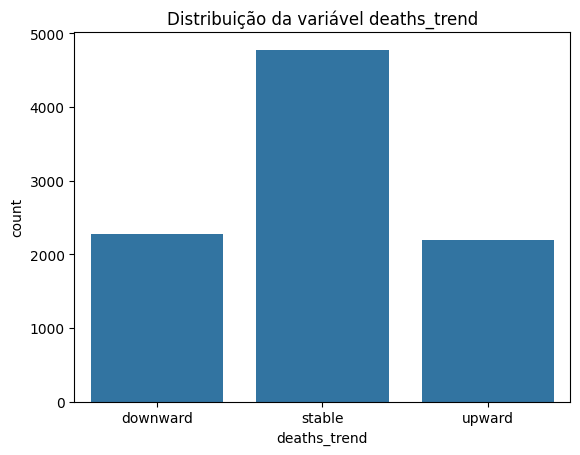

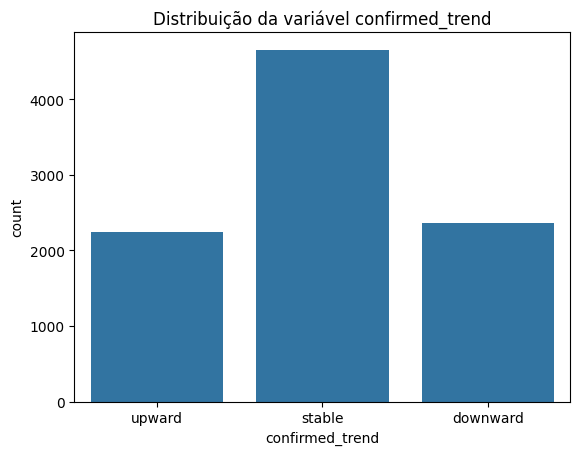

In [57]:
for col in categorical:
    sns.countplot(x = col, data = cases)
    plt.title(f'Distribuição da variável {col}')
    plt.show()

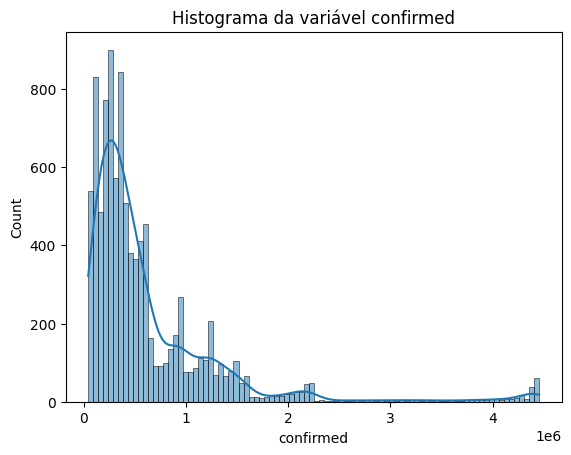

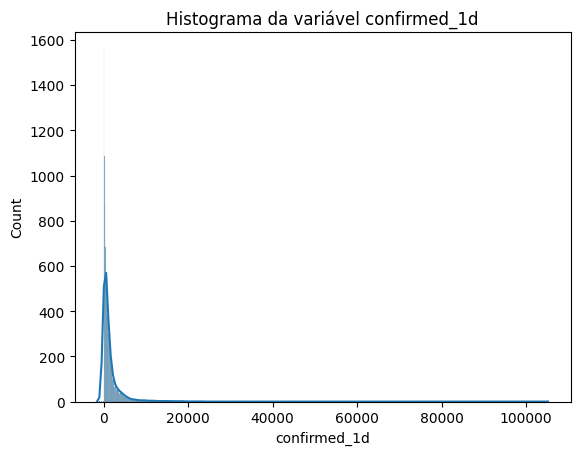

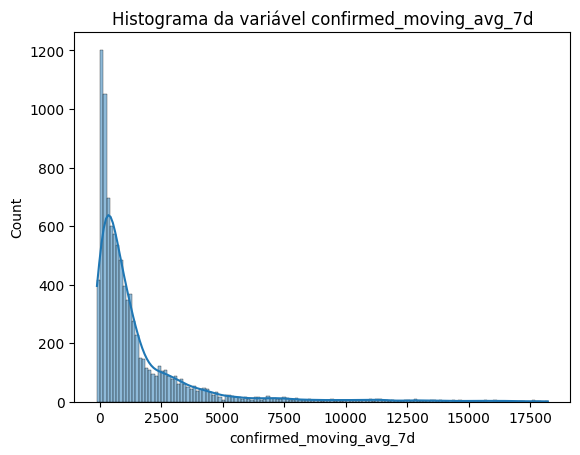

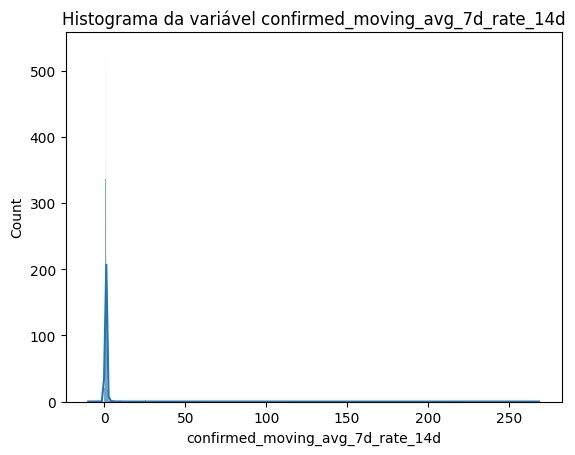

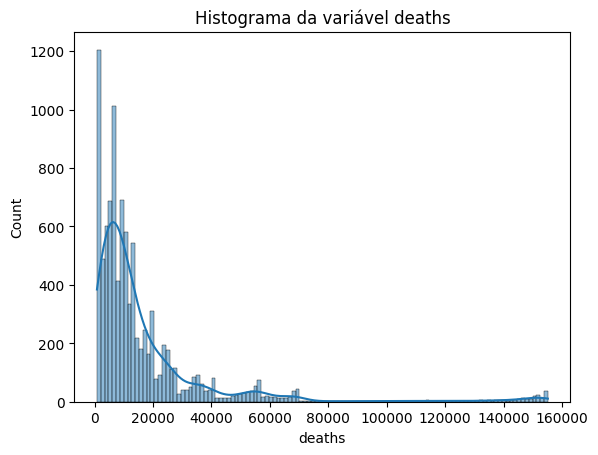

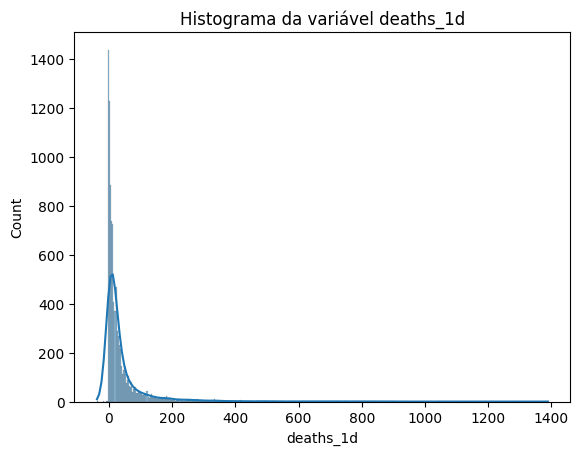

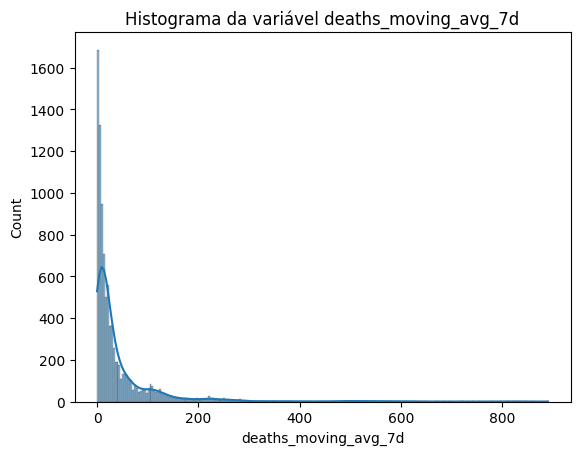

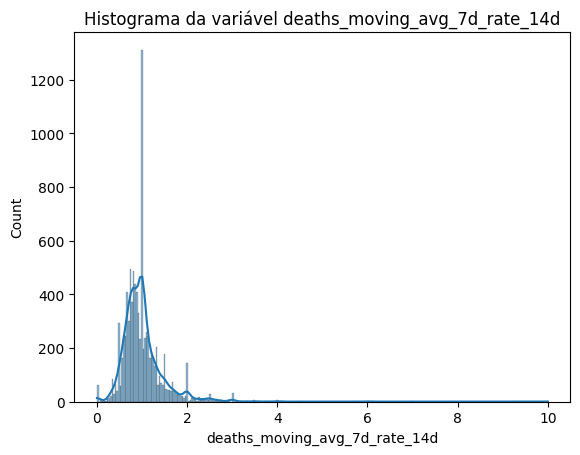

In [58]:
for col in numerical:
    sns.histplot(x = col, data = cases, kde = True)
    plt.title(f'Histograma da variável {col}')
    plt.show()

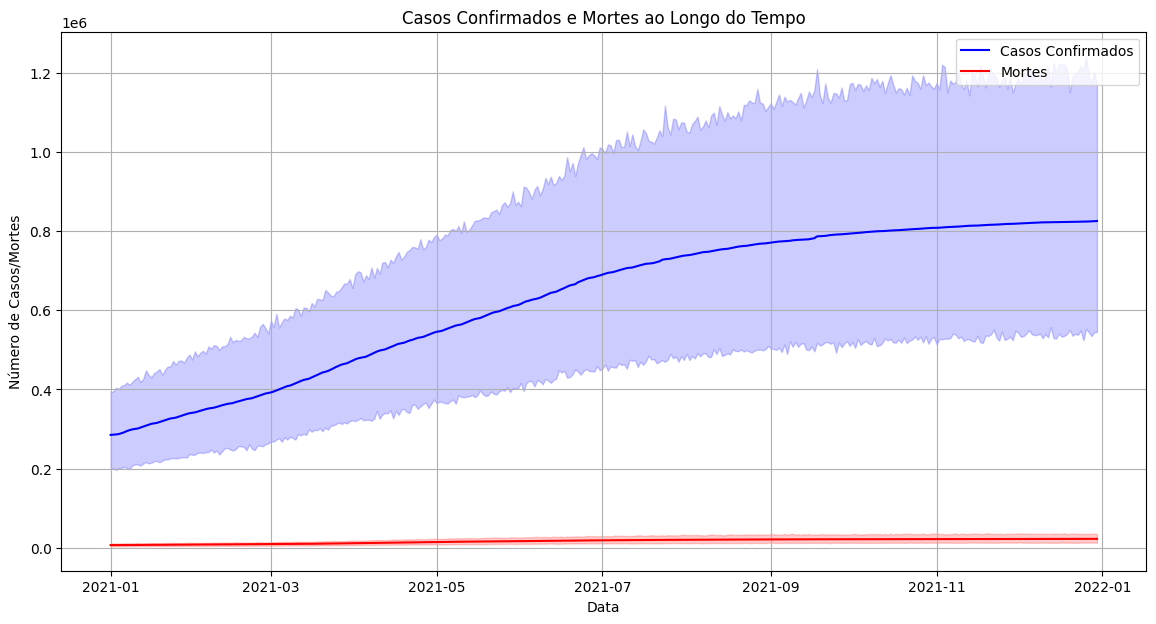

In [39]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=cases, x='date', y='confirmed', label='Casos Confirmados', color='blue')
sns.lineplot(data=cases, x='date', y='deaths', label='Mortes', color='red')
plt.title('Casos Confirmados e Mortes ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Número de Casos/Mortes')
plt.legend()
plt.grid(True)
plt.show()

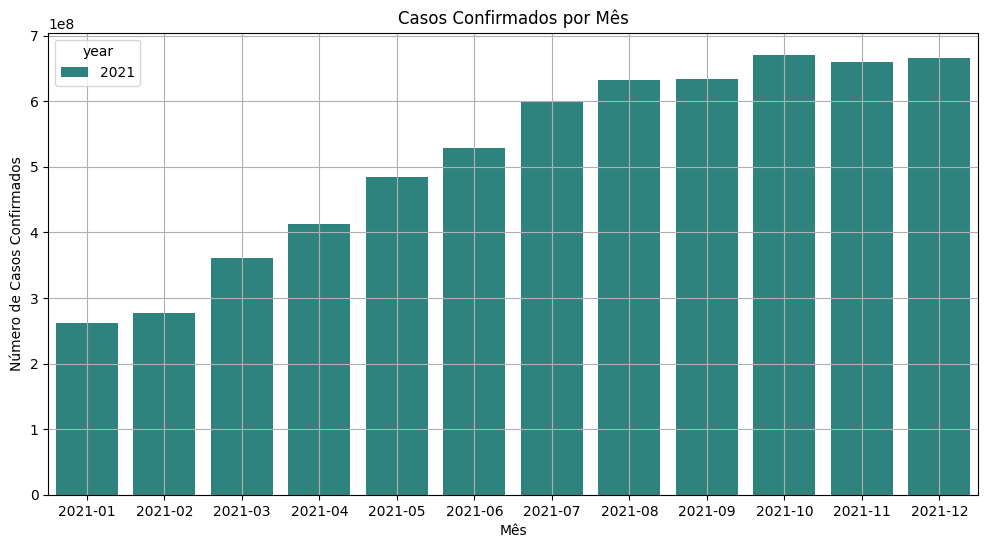

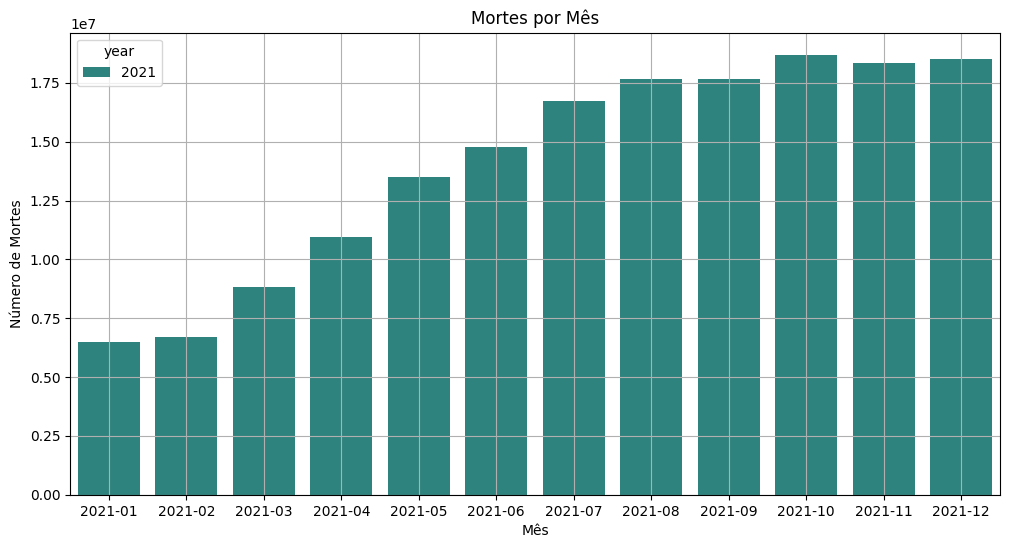

In [40]:
plt.figure(figsize=(12, 6))
monthly_cases = cases.groupby(['year', 'month'])['confirmed'].sum().reset_index()
monthly_deaths = cases.groupby(['year', 'month'])['deaths'].sum().reset_index()

sns.barplot(data=monthly_cases, x='month', y='confirmed', hue='year', palette='viridis')
plt.title('Casos Confirmados por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Casos Confirmados')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_deaths, x='month', y='deaths', hue='year', palette='viridis')
plt.title('Mortes por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Mortes')
plt.grid(True)
plt.show()


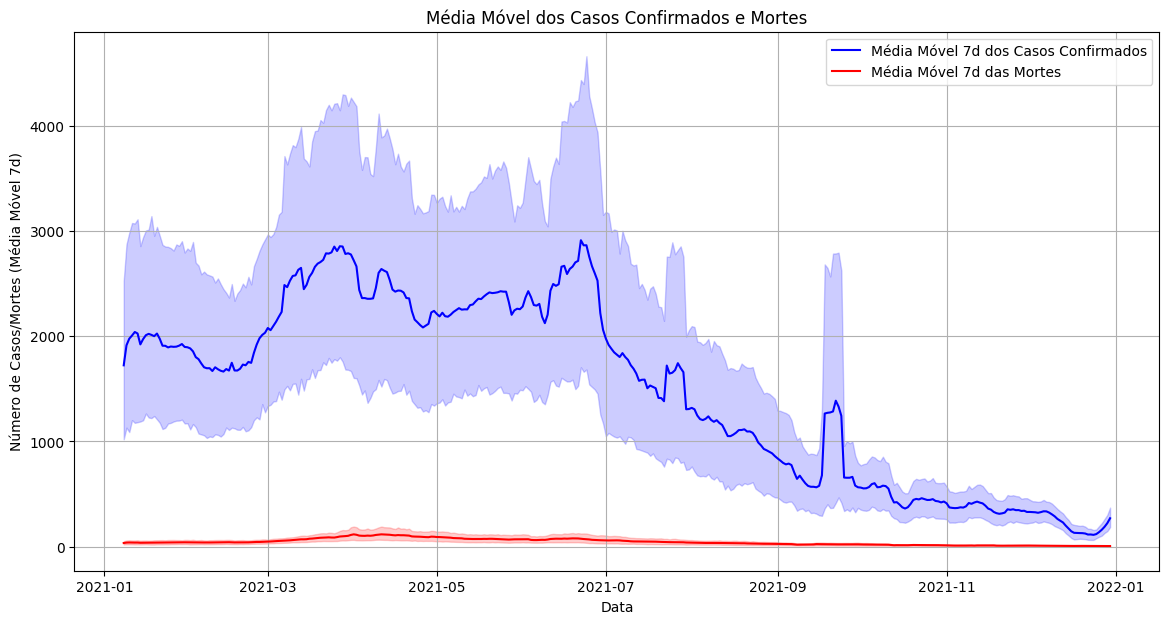

In [41]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=cases, x='date', y='confirmed_moving_avg_7d', label='Média Móvel 7d dos Casos Confirmados', color='blue')
sns.lineplot(data=cases, x='date', y='deaths_moving_avg_7d', label='Média Móvel 7d das Mortes', color='red')
plt.title('Média Móvel dos Casos Confirmados e Mortes')
plt.xlabel('Data')
plt.ylabel('Número de Casos/Mortes (Média Móvel 7d)')
plt.legend()
plt.grid(True)
plt.show()


4. Dashboard